In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import pandas as pd
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, vmap
from utils.utils_temp_spat_grad import ClimateDownscalingLossJAX
from utils.funs import is_leap_year, compute_day_of_year, compute_year_progress, compute_sin_cos_year_progress, normalize_to_unit_interval 

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

2024-11-05 16:40:36.282644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730846436.301471   19307 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730846436.307089   19307 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 16:40:40.816660: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


#### Data Handling: load and resample data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_data_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})


# Normalize the data (standardization)
def normalize(data):
    mean = data.mean().compute().item()
    std = data.std().compute().item()
    return (data - mean) / std

cmip6_data_norm = normalize(cmip6_high_res['tas'])
gmfd_data_norm = normalize(gmfd_data['tas'])

# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
gmfd_train = gmfd_data_norm.values

#### Add covariates
Add the sine and cosine of the of year progress (normalized to [0,1]).

In [3]:
# Assuming compute_year_progress, compute_sin_cos_year_progress, and normalize_to_unit_interval are defined

# Generate the date range
start_date = pd.Timestamp('1950-01-01')
date_range = pd.date_range(start=start_date, periods=23741, freq='D')

# Compute and normalize sine and cosine of year progress for each date
sin_values = []
cos_values = []
for date in date_range:
    year_progress = compute_year_progress(date)
    sin_progress, cos_progress = compute_sin_cos_year_progress(year_progress)
    
    # Normalize
    sin_values.append(normalize_to_unit_interval(sin_progress))
    cos_values.append(normalize_to_unit_interval(cos_progress))

# Convert sine and cosine values to NumPy arrays
sin_values = np.array(sin_values)  # Shape (23741,)
cos_values = np.array(cos_values)  # Shape (23741,)

# Reshape sine and cosine arrays to match the spatial dimensions of cmip6_train
# sin_values and cos_values are (23741,)
# We need to expand them to (23741, 42, 97, 1) to match cmip6_train

# Reshape sin_values and cos_values and expand them across the spatial dimensions (42, 97)
sin_expanded = sin_values[:, np.newaxis, np.newaxis, np.newaxis]  # Shape (23741, 1, 1, 1)
sin_expanded = np.tile(sin_expanded, (1, 42, 97, 1))  # Shape (23741, 42, 97, 1)

cos_expanded = cos_values[:, np.newaxis, np.newaxis, np.newaxis]  # Shape (23741, 1, 1, 1)
cos_expanded = np.tile(cos_expanded, (1, 42, 97, 1))  # Shape (23741, 42, 97, 1)

# Expand cmip6_train along the last dimension to add an extra channel
# cmip6_train originally has shape (23741, 42, 97), we want to make it (23741, 42, 97, 1)
cmip6_train_expanded = cmip6_train[:, :, :, np.newaxis]  # Shape (23741, 42, 97, 1)
gmfd_train_expanded = gmfd_train[:, :, :, np.newaxis]  # Shape (23741, 42, 97, 1)

# Now cmip6_train_expanded, sin_expanded, and cos_expanded all have shape (23741, 42, 97, 1)
# Concatenate along the last dimension to get a shape of (23741, 42, 97, 3)
cmip6_train_expanded = np.concatenate([cmip6_train_expanded, sin_expanded, cos_expanded], axis=-1)
gmfd_train_expanded = np.concatenate([gmfd_train_expanded, sin_expanded, cos_expanded], axis=-1)



#### Build the UNet Model (Keras with JAX Backend)
Now let's define a simple UNet model using Keras with JAX backend. Our model will take the coarse-resolution CMIP6 data and predict the high-resolution GMFD data.



In [21]:
def climate_unet(input_shape=(42, 97, 3), n_filters=64):
    """
    Enhanced U-Net architecture for climate downscaling with:
        - Squeeze-and-Excitation blocks for better feature recalibration
        - Multi-scale feature fusion
        - Dilated convolutions in bottleneck
        - Improved attention mechanisms
        - Deeper feature extraction
        - Additional regularization techniques
    """
    from tensorflow import keras
    from tensorflow.keras import layers
    import tensorflow as tf
    
    inputs = keras.Input(shape=input_shape)
    
    # Initial processing with multi-scale input
    x = layers.BatchNormalization()(inputs)
    
    def squeeze_excite_block(input_tensor, ratio=16):
        """Squeeze and Excitation block for channel attention"""
        channels = input_tensor.shape[-1]
        squeeze = layers.GlobalAveragePooling2D()(input_tensor)
        
        excitation = layers.Dense(channels // ratio, activation='relu')(squeeze)
        excitation = layers.Dense(channels, activation='sigmoid')(excitation)
        excitation = layers.Reshape((1, 1, channels))(excitation)
        
        scale = layers.multiply([input_tensor, excitation])
        return scale
    
    def enhanced_conv_block(x, filters, kernel_size=3, dilation_rate=1):
        """Enhanced convolution block with improved feature extraction"""
        conv = layers.Conv2D(filters, kernel_size, padding='same', 
                           dilation_rate=dilation_rate)(x)
        conv = layers.LeakyReLU(negative_slope=0.2)(conv)  # Updated parameter name
        conv = layers.BatchNormalization()(conv)
        return conv
    
    def encoder_block(x, filters, dropout_rate=0.1):
        # Multi-scale feature extraction
        conv3x3 = enhanced_conv_block(x, filters)
        conv5x5 = enhanced_conv_block(x, filters, kernel_size=5)
        conv = layers.Concatenate()([conv3x3, conv5x5])
        conv = layers.Conv2D(filters, 1, padding='same')(conv)  # 1x1 conv to reduce channels
        
        # Double conv with residual
        conv = enhanced_conv_block(conv, filters)
        conv = enhanced_conv_block(conv, filters)
        
        # Residual connection
        res = layers.Conv2D(filters, 1, padding='same')(x)
        conv = layers.Add()([conv, res])
        
        # Squeeze and Excitation
        conv = squeeze_excite_block(conv)
        
        # Spatial attention
        spatial_attention = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(conv)
        conv = layers.multiply([conv, spatial_attention])
        
        conv = layers.SpatialDropout2D(dropout_rate)(conv)
        pool = layers.MaxPooling2D(pool_size=(2, 2))(conv)
        
        return conv, pool
    
    # Encoder path with progressive feature growth
    conv1, pool1 = encoder_block(x, n_filters)
    conv2, pool2 = encoder_block(pool1, n_filters*2)
    conv3, pool3 = encoder_block(pool2, n_filters*4)
    conv4, pool4 = encoder_block(pool3, n_filters*8)
    
    # Enhanced middle block with dilated convolutions
    mid = enhanced_conv_block(pool4, n_filters*16, dilation_rate=2)
    mid = enhanced_conv_block(mid, n_filters*16, dilation_rate=4)
    mid = enhanced_conv_block(mid, n_filters*16, dilation_rate=8)
    mid = layers.SpatialDropout2D(0.3)(mid)
    
    def decoder_block(x, skip_connection, filters, dropout_rate=0.1):
        # Upsampling with learnable parameters
        up = layers.Conv2DTranspose(filters, 3, strides=2, padding='same')(x)
        
        # Handle size mismatches
        if up.shape[1] != skip_connection.shape[1] or up.shape[2] != skip_connection.shape[2]:
            up = layers.Resizing(skip_connection.shape[1], skip_connection.shape[2])(up)
        
        # Multi-scale skip connection processing
        skip_proc = enhanced_conv_block(skip_connection, filters)
        concat = layers.concatenate([up, skip_proc])
        
        # Enhanced decoding path
        conv = enhanced_conv_block(concat, filters)
        conv = enhanced_conv_block(conv, filters)
        
        # Residual connection
        res = layers.Conv2D(filters, 1, padding='same')(concat)
        conv = layers.Add()([conv, res])
        
        # Squeeze and Excitation
        conv = squeeze_excite_block(conv)
        
        conv = layers.SpatialDropout2D(dropout_rate)(conv)
        return conv
    
    # Decoder path with skip connections
    up4 = decoder_block(mid, conv4, n_filters*8)
    up3 = decoder_block(up4, conv3, n_filters*4)
    up2 = decoder_block(up3, conv2, n_filters*2)
    up1 = decoder_block(up2, conv1, n_filters)
    
    # Enhanced final convolution blocks
    final = enhanced_conv_block(up1, n_filters)
    final = enhanced_conv_block(final, n_filters)
    final = squeeze_excite_block(final)
    
    # Multi-scale output fusion (modified for 3 channels)
    output_1 = layers.Conv2D(3, 1, padding='same')(final)  # Changed to 3 channels
    output_3 = layers.Conv2D(3, 3, padding='same')(final)  # Changed to 3 channels
    output_5 = layers.Conv2D(3, 5, padding='same')(final)  # Changed to 3 channels
    output_fusion = layers.Average()([output_1, output_3, output_5])
    
    # Residual connection from input (maintaining 3 channels)
    outputs = layers.Add()([output_fusion, inputs])
    
    # Final scale calibration with 3 channels
    outputs = layers.Conv2D(3, 1, activation='linear', padding='same')(outputs)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
input_shape = (42, 97, 3)
model = climate_unet(input_shape)

#### Split the data
Train set: The first portion of the time period (e.g., 60% of the time series).
Validation set: The next portion of the time series (e.g., the following 20% of the time series).
Test set: The final portion of the time series (e.g., the last 20%): 

In [22]:
# The data already has channels, so no need to add a new dimension
cmip6_train_reshaped = cmip6_train_expanded  # Shape: (23741, 42, 97, 3)
gmfd_train_reshaped = gmfd_train_expanded    # Shape: (23741, 42, 97, 3)

# Get the total number of time steps
n_samples = cmip6_train_reshaped.shape[0]  # 23741

# Split indices based on time series order
train_size = int(n_samples * 0.7)    # 70% for training
val_size = int(n_samples * 0.15)     # 15% for validation
test_size = n_samples - train_size - val_size  # 15% for test

# Split the data while preserving the temporal structure
X_train = cmip6_train_reshaped[:train_size]           # Shape: (~16618, 42, 97, 3)
y_train = gmfd_train_reshaped[:train_size]            # Shape: (~16618, 42, 97, 3)

X_val = cmip6_train_reshaped[train_size:train_size + val_size]  # Shape: (~3561, 42, 97, 3)
y_val = gmfd_train_reshaped[train_size:train_size + val_size]   # Shape: (~3561, 42, 97, 3)

X_test = cmip6_train_reshaped[train_size + val_size:]  # Shape: (~3562, 42, 97, 3)
y_test = gmfd_train_reshaped[train_size + val_size:]   # Shape: (~3562, 42, 97, 3)

# Verify the shapes
print("Training shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Testing shapes:", X_test.shape, y_test.shape)

Training shapes: (16618, 42, 97, 3) (16618, 42, 97, 3)
Validation shapes: (3561, 42, 97, 3) (3561, 42, 97, 3)
Testing shapes: (3562, 42, 97, 3) (3562, 42, 97, 3)


#### Train the model

In [24]:
# Assuming climate_unet and ClimateDownscalingLossJAX are defined elsewhere
input_shape = (cmip6_train_reshaped.shape[1], cmip6_train_reshaped.shape[2], 3)
model = climate_unet(input_shape)

# Mixed Precision (if supported by your hardware)
# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

epochs = 300
batch_size = 32

# Learning rate schedule with warmup and cosine decay
initial_learning_rate = 1e-3
total_steps = int(np.ceil(len(X_train) / batch_size)) * epochs

lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps=total_steps // 4,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-5
)

# Optimizer configuration
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)

# Initialize the custom loss function

climate_loss = ClimateDownscalingLossJAX()
#climate_loss = tf.keras.losses.MeanSquaredError() # Note: tf.keras.losses, not tf.keras.metrics


# ... later in model.compile ...
model.compile(
    optimizer=optimizer,
    loss=climate_loss, # Or directly use 'mse' as a string
    # ... other arguments
)


# ... and in model.compile ...
model.compile(
    optimizer=optimizer,
    loss=climate_loss, # Or directly use 'mae' as a string
    # ...
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Simplified callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=15,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'models/unet_time_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,  # Ensure the whole model is saved
        mode='min',  # Use 'min' to minimize the validation loss
        verbose=1  # Add verbosity to see when checkpoints are saved
    ),
    keras.callbacks.TerminateOnNaN()
]

# Calculate total batches
total_batches = int(np.ceil(len(X_train) / batch_size) * epochs)

# Initialize history
history = {
    'loss': [],
    'val_loss': [],
    'mean_absolute_error': [],
    'val_mean_absolute_error': [],
    'root_mean_squared_error': [],
    'val_root_mean_squared_error': [],
    'learning_rate': []
}

# Training loop
with tqdm(total=total_batches, desc='Training', unit='batch') as pbar:
    for epoch in range(epochs):
        # Training epoch
        history_epoch = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=1,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0,
            shuffle = True
        )
        
        # Update history
        for key in history_epoch.history:
            history[key].append(history_epoch.history[key][0])
        
        # Get current learning rate (general method)
        current_lr = tf.keras.backend.get_value(model.optimizer.learning_rate)
        
        # Append learning rate to history
        history['learning_rate'].append(current_lr)

        # Update progress bar
        pbar.set_postfix({
            'epoch': epoch + 1,
            'loss': f"{history['loss'][-1]:.4f}",
            'val_loss': f"{history['val_loss'][-1]:.4f}",
            'train_mae': f"{history['val_mean_absolute_error'][-1]:.4f}",
            'val_mae': f"{history['mean_absolute_error'][-1]:.4f}",
            'lr': f"{current_lr:.2e}"
        })
        
        # Update progress
        pbar.update(int(np.ceil(len(X_train) / batch_size)))
        
        # Early stopping check
        if len(history['val_loss']) > 20:
            best_loss = min(history['val_loss'][:-20])
            recent_best = min(history['val_loss'][-20:])
            if recent_best >= best_loss and current_lr <= 1e-5:
                print("\nEarly stopping triggered: No improvement in validation loss")
                break

print("\nTraining completed. Final metrics:")

# Loop through history and print the last recorded value for each metric, except learning_rate
for key in history:
    if key != 'learning_rate' and len(history[key]) > 0:
        print(f"{key}: {history[key][-1]:.4f}")

# Print the best validation loss and optionally the epoch where it occurred
if 'val_loss' in history and len(history['val_loss']) > 0:
    best_val_loss = min(history['val_loss'])
    best_epoch = history['val_loss'].index(best_val_loss) + 1
    print(f"Best validation loss: {best_val_loss:.4f} (Epoch {best_epoch})")
else:
    print("Validation loss history is empty.")

Training:   0%|                                                                                                   | 0/156000 [00:00<?, ?batch/s]


Epoch 1: val_loss improved from inf to 0.06465, saving model to models/unet_time_best_model.keras


Training:   0%|                       | 520/156000 [01:55<9:36:38,  4.49batch/s, epoch=1, loss=0.0970, val_loss=0.0647, mae=0.1875, lr=1.00e-03]


Epoch 1: val_loss did not improve from 0.06465


Training:   1%|▏                     | 1040/156000 [02:55<6:20:21,  6.79batch/s, epoch=2, loss=0.0751, val_loss=0.0656, mae=0.1543, lr=9.98e-04]


Epoch 1: val_loss improved from 0.06465 to 0.06184, saving model to models/unet_time_best_model.keras


Training:   1%|▏                     | 1560/156000 [03:25<4:31:17,  9.49batch/s, epoch=3, loss=0.0709, val_loss=0.0618, mae=0.1447, lr=9.96e-04]


Epoch 1: val_loss did not improve from 0.06184


Training:   1%|▎                     | 2080/156000 [03:55<3:35:23, 11.91batch/s, epoch=4, loss=0.0682, val_loss=0.0619, mae=0.1396, lr=9.93e-04]


Epoch 1: val_loss improved from 0.06184 to 0.06023, saving model to models/unet_time_best_model.keras


Training:   2%|▎                     | 2600/156000 [04:25<3:09:44, 13.47batch/s, epoch=5, loss=0.0667, val_loss=0.0602, mae=0.1363, lr=9.89e-04]


Epoch 1: val_loss improved from 0.06023 to 0.05916, saving model to models/unet_time_best_model.keras


Training:   2%|▍                     | 3120/156000 [04:55<2:52:38, 14.76batch/s, epoch=6, loss=0.0659, val_loss=0.0592, mae=0.1341, lr=9.84e-04]


Epoch 1: val_loss did not improve from 0.05916


Training:   2%|▌                     | 3640/156000 [05:15<2:37:48, 16.09batch/s, epoch=7, loss=0.0657, val_loss=0.0595, mae=0.1341, lr=9.79e-04]


Epoch 1: val_loss improved from 0.05916 to 0.05833, saving model to models/unet_time_best_model.keras


Training:   3%|▌                     | 4160/156000 [05:45<2:31:38, 16.69batch/s, epoch=8, loss=0.0648, val_loss=0.0583, mae=0.1320, lr=9.72e-04]


Epoch 1: val_loss improved from 0.05833 to 0.05764, saving model to models/unet_time_best_model.keras


Training:   3%|▋                     | 4680/156000 [06:15<2:27:22, 17.11batch/s, epoch=9, loss=0.0641, val_loss=0.0576, mae=0.1291, lr=9.65e-04]


Epoch 1: val_loss improved from 0.05764 to 0.05745, saving model to models/unet_time_best_model.keras


Training:   3%|▋                    | 5200/156000 [06:45<2:24:26, 17.40batch/s, epoch=10, loss=0.0640, val_loss=0.0574, mae=0.1287, lr=9.57e-04]


Epoch 1: val_loss improved from 0.05745 to 0.05713, saving model to models/unet_time_best_model.keras


Training:   4%|▊                    | 5720/156000 [07:15<2:22:05, 17.63batch/s, epoch=11, loss=0.0631, val_loss=0.0571, mae=0.1264, lr=9.48e-04]


Epoch 1: val_loss did not improve from 0.05713


Training:   4%|▊                    | 6240/156000 [07:45<2:18:08, 18.07batch/s, epoch=12, loss=0.0629, val_loss=0.0583, mae=0.1260, lr=9.38e-04]


Epoch 1: val_loss did not improve from 0.05713


Training:   4%|▉                    | 6760/156000 [08:05<2:14:06, 18.55batch/s, epoch=13, loss=0.0628, val_loss=0.0578, mae=0.1254, lr=9.28e-04]


Epoch 1: val_loss did not improve from 0.05713


Training:   5%|▉                    | 7280/156000 [08:35<2:11:08, 18.90batch/s, epoch=14, loss=0.0627, val_loss=0.0585, mae=0.1244, lr=9.16e-04]


Epoch 1: val_loss did not improve from 0.05713


Training:   5%|█                    | 7800/156000 [09:05<2:08:53, 19.16batch/s, epoch=15, loss=0.0622, val_loss=0.0599, mae=0.1245, lr=9.05e-04]


Epoch 1: val_loss did not improve from 0.05713


Training:   5%|█                    | 8320/156000 [09:25<2:07:06, 19.36batch/s, epoch=16, loss=0.0620, val_loss=0.0580, mae=0.1233, lr=8.92e-04]


Epoch 1: val_loss did not improve from 0.05713


Training:   6%|█▏                   | 8840/156000 [09:55<2:05:41, 19.51batch/s, epoch=17, loss=0.0618, val_loss=0.0591, mae=0.1228, lr=8.78e-04]


Epoch 1: val_loss improved from 0.05713 to 0.05685, saving model to models/unet_time_best_model.keras


Training:   6%|█▎                   | 9360/156000 [10:25<2:08:09, 19.07batch/s, epoch=18, loss=0.0620, val_loss=0.0568, mae=0.1230, lr=8.64e-04]


Epoch 1: val_loss did not improve from 0.05685


Training:   6%|█▎                   | 9880/156000 [10:45<2:06:36, 19.24batch/s, epoch=19, loss=0.0615, val_loss=0.0575, mae=0.1215, lr=8.50e-04]


Epoch 1: val_loss did not improve from 0.05685


Training:   7%|█▎                  | 10400/156000 [11:15<2:07:19, 19.06batch/s, epoch=20, loss=0.0615, val_loss=0.0569, mae=0.1218, lr=8.35e-04]


Epoch 1: val_loss improved from 0.05685 to 0.05662, saving model to models/unet_time_best_model.keras


Training:   7%|█▍                  | 10920/156000 [11:45<2:08:44, 18.78batch/s, epoch=21, loss=0.0612, val_loss=0.0566, mae=0.1209, lr=8.19e-04]


Epoch 1: val_loss did not improve from 0.05662


Training:   7%|█▍                  | 11440/156000 [12:15<2:06:21, 19.07batch/s, epoch=22, loss=0.0611, val_loss=0.0575, mae=0.1207, lr=8.02e-04]


Epoch 1: val_loss did not improve from 0.05662


Training:   8%|█▌                  | 11960/156000 [12:35<2:04:27, 19.29batch/s, epoch=23, loss=0.0610, val_loss=0.0573, mae=0.1201, lr=7.85e-04]


Epoch 1: val_loss did not improve from 0.05662


Training:   8%|█▌                  | 12480/156000 [13:05<2:03:06, 19.43batch/s, epoch=24, loss=0.0610, val_loss=0.0567, mae=0.1204, lr=7.68e-04]


Epoch 1: val_loss did not improve from 0.05662


Training:   8%|█▋                  | 13000/156000 [13:25<2:02:23, 19.47batch/s, epoch=25, loss=0.0608, val_loss=0.0571, mae=0.1197, lr=7.50e-04]


Epoch 1: val_loss did not improve from 0.05662


Training:   9%|█▋                  | 13520/156000 [13:55<2:01:17, 19.58batch/s, epoch=26, loss=0.0606, val_loss=0.0567, mae=0.1195, lr=7.32e-04]


Epoch 1: val_loss did not improve from 0.05662


Training:   9%|█▊                  | 14040/156000 [14:25<2:00:42, 19.60batch/s, epoch=27, loss=0.0606, val_loss=0.0573, mae=0.1195, lr=7.13e-04]


Epoch 1: val_loss improved from 0.05662 to 0.05641, saving model to models/unet_time_best_model.keras


Training:   9%|█▊                  | 14560/156000 [14:55<2:04:08, 18.99batch/s, epoch=28, loss=0.0605, val_loss=0.0564, mae=0.1193, lr=6.94e-04]


Epoch 1: val_loss improved from 0.05641 to 0.05619, saving model to models/unet_time_best_model.keras


Training:  10%|█▉                  | 15080/156000 [15:25<2:05:25, 18.73batch/s, epoch=29, loss=0.0605, val_loss=0.0562, mae=0.1195, lr=6.74e-04]


Epoch 1: val_loss did not improve from 0.05619


Training:  10%|██                  | 15600/156000 [15:45<2:03:15, 18.98batch/s, epoch=30, loss=0.0605, val_loss=0.0573, mae=0.1192, lr=6.55e-04]


Epoch 1: val_loss did not improve from 0.05619


Training:  10%|██                  | 16120/156000 [16:15<2:01:28, 19.19batch/s, epoch=31, loss=0.0603, val_loss=0.0565, mae=0.1184, lr=6.34e-04]


Epoch 1: val_loss did not improve from 0.05619


Training:  11%|██▏                 | 16640/156000 [16:35<2:00:02, 19.35batch/s, epoch=32, loss=0.0603, val_loss=0.0568, mae=0.1186, lr=6.14e-04]


Epoch 1: val_loss did not improve from 0.05619


Training:  11%|██▏                 | 17160/156000 [17:05<1:58:36, 19.51batch/s, epoch=33, loss=0.0602, val_loss=0.0566, mae=0.1180, lr=5.94e-04]


Epoch 1: val_loss improved from 0.05619 to 0.05616, saving model to models/unet_time_best_model.keras


Training:  11%|██▎                 | 17680/156000 [17:35<2:00:28, 19.13batch/s, epoch=34, loss=0.0601, val_loss=0.0562, mae=0.1177, lr=5.73e-04]


Epoch 1: val_loss did not improve from 0.05616


Training:  12%|██▎                 | 18200/156000 [18:05<1:59:52, 19.16batch/s, epoch=35, loss=0.0599, val_loss=0.0565, mae=0.1173, lr=5.52e-04]


Epoch 1: val_loss improved from 0.05616 to 0.05605, saving model to models/unet_time_best_model.keras


Training:  12%|██▍                 | 18720/156000 [18:25<2:01:01, 18.91batch/s, epoch=36, loss=0.0598, val_loss=0.0561, mae=0.1171, lr=5.31e-04]


Epoch 1: val_loss did not improve from 0.05605


Training:  12%|██▍                 | 19240/156000 [18:55<1:59:33, 19.06batch/s, epoch=37, loss=0.0597, val_loss=0.0566, mae=0.1169, lr=5.10e-04]


Epoch 1: val_loss did not improve from 0.05605


Training:  13%|██▌                 | 19760/156000 [19:25<1:57:46, 19.28batch/s, epoch=38, loss=0.0597, val_loss=0.0568, mae=0.1168, lr=4.90e-04]


Epoch 1: val_loss did not improve from 0.05605


Training:  13%|██▌                 | 20280/156000 [19:45<1:56:24, 19.43batch/s, epoch=39, loss=0.0597, val_loss=0.0561, mae=0.1168, lr=4.69e-04]


Epoch 1: val_loss did not improve from 0.05605


Training:  13%|██▋                 | 20800/156000 [20:15<1:55:07, 19.57batch/s, epoch=40, loss=0.0597, val_loss=0.0567, mae=0.1172, lr=4.48e-04]


Epoch 1: val_loss did not improve from 0.05605


Training:  14%|██▋                 | 21320/156000 [20:45<1:54:07, 19.67batch/s, epoch=41, loss=0.0596, val_loss=0.0566, mae=0.1166, lr=4.27e-04]


Epoch 1: val_loss did not improve from 0.05605


Training:  14%|██▊                 | 21840/156000 [21:19<2:10:57, 17.07batch/s, epoch=42, loss=0.0594, val_loss=0.0564, mae=0.1161, lr=4.06e-04]


KeyboardInterrupt: 

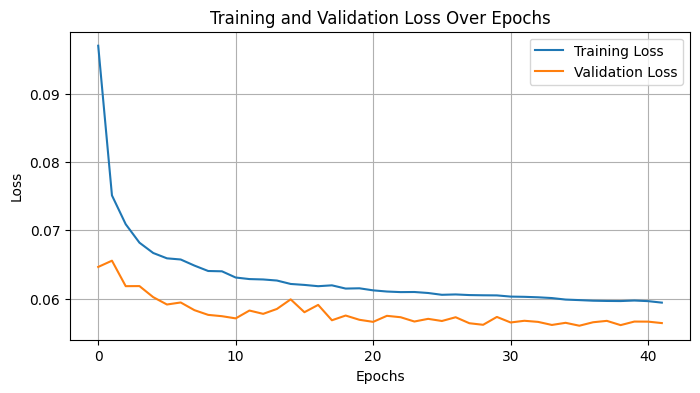

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0,0.6)
plt.legend()
plt.grid()
plt.show()

#### Evaluate the model on validation data

In [34]:

print(y_pred[:,:,:,0].shape)

IndexError: index 3 is out of bounds for axis 3 with size 3

112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step


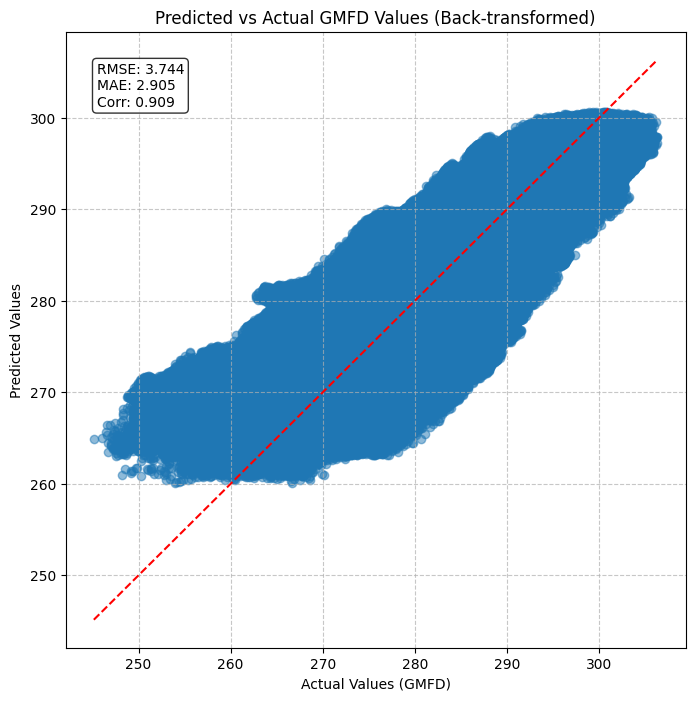

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Load the model
from keras.models import load_model
model_best = load_model(
    'models/unet_time_best_model.keras',
    custom_objects={'ClimateDownscalingLossJAX': ClimateDownscalingLossJAX}
)

# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values

# Get the mean and std from the training set for denormalization
gmfd_mean = gmfd_data['tas'].mean().values
gmfd_std = gmfd_data['tas'].std().values

# Generate predictions on validation data
y_pred = model_best.predict(X_test)

# Back-transform the predictions for evaluation only for climate variable
y_val_denorm =  (y_test[:,:,:,0] * gmfd_std) + gmfd_mean
y_pred_denorm = (y_pred[:,:,:,0] * cmip6_high_res_std) + cmip6_high_res_mean

# Calculate RMSE, MAE, and correlation
rmse = np.sqrt(mean_squared_error(y_val_denorm.flatten(), y_pred_denorm.flatten()))
mae = mean_absolute_error(y_val_denorm.flatten(), y_pred_denorm.flatten())
correlation = np.corrcoef(y_val_denorm.flatten(), y_pred_denorm.flatten())[0,1]

# Create the plot
plt.figure(figsize=(8, 8))
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid
plt.scatter(y_val_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
plt.xlabel('Actual Values (GMFD)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual GMFD Values (Back-transformed)')
plt.plot([y_val_denorm.min(), y_val_denorm.max()], 
         [y_val_denorm.min(), y_val_denorm.max()], 'r--')

# Add RMSE, MAE, and correlation text to the upper left
plt.text(0.05, 0.95, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nCorr: {correlation:.3f}',  
         transform=plt.gca().transAxes, 
         verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

#### Train the Best Model on All Data
Train the model on all the data (no splitting)

In [12]:

climate_loss = ClimateDownscalingLossJAX()
epochs = 300
batch_size = 32

patience = max(1, int(epochs * 0.1))  # Set patience to 10% of epochs, with a minimum of 1


# Define input shape and initialize model
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)  # Assuming 1 channel (tas)
model = climate_unet(input_shape)

# Load pretrained weights
model.load_weights('models/unet_best_model.keras')
print("Loaded pretrained weights from the best model.")

# Learning rate and optimizer configuration (removing warmup cosine decay)
learning_rate = 1e-3  # Directly using the inherited best model's learning rate
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,  # Use custom climate loss function
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)


# Callbacks for fine-tuning with validation monitoring
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',         
        patience=patience,             # Adjusted patience based on expected number of epochs
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'models/unet_fine_tuned_model.keras',  # Unique filename with timestamp
        monitor='val_loss',         
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.TerminateOnNaN()
]

# Fine-tune the model on all data with validation
history = model.fit(
    cmip6_train_reshaped,             # Full dataset input
    gmfd_train_reshaped,              # Full dataset target
    validation_data=(X_val, y_val),   # Add validation data here
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    shuffle=True,
    verbose=1  
)

# Final evaluation on the test set if available, otherwise on training set
if 'X_test' in globals() and 'y_test' in globals():
    print("Final evaluation on the test set:")
    results = model.evaluate(X_test, y_test, verbose=1)
else:
    print("Final evaluation on all training data:")
    results = model.evaluate(cmip6_train_reshaped, gmfd_train_reshaped, verbose=1)

# Print final performance metrics
print(f"Loss: {results[0]:.4f}, MAE: {results[1]:.4f}, RMSE: {results[2]:.4f}")


Loaded pretrained weights from the best model.
Epoch 1/300
742/742 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2530 - mean_absolute_error: 0.3502 - root_mean_squared_error: 0.4540
Epoch 1: val_loss improved from inf to 0.18315, saving model to models/unet_fine_tuned_model.keras
742/742 ━━━━━━━━━━━━━━━━━━━━ 118s 116ms/step - loss: 0.2530 - mean_absolute_error: 0.3502 - root_mean_squared_error: 0.4540 - val_loss: 0.1831 - val_mean_absolute_error: 0.3574 - val_root_mean_squared_error: 0.4583 - learning_rate: 0.0010
Epoch 2/300
742/742 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2472 - mean_absolute_error: 0.3458 - root_mean_squared_error: 0.4476
Epoch 2: val_loss improved from 0.18315 to 0.18151, saving model to models/unet_fine_tuned_model.keras
742/742 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - loss: 0.2472 - mean_absolute_error: 0.3458 - root_mean_squared_error: 0.4476 - val_loss: 0.1815 - val_mean_absolute_error: 0.3596 - val_root_mean_squared_error: 0.4588 - learning_rate: 0.0010
Epoch 3/3

KeyboardInterrupt: 

#### Pred on historical data

In [48]:
# Load the model
from keras.models import load_model
model_saved = load_model(
    'models/unet_best_model.keras',
    custom_objects={'ClimateDownscalingLossJAX': ClimateDownscalingLossJAX}
)

# Predict downscaled high-resolution data
predicted_high_res = model_saved.predict(cmip6_train_reshaped)

742/742 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step


In [49]:
# Inverse transform the predictions to get the actual temperature values


# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values

# Back-transform the predictions and actual values
predicted_high_res_denorm = (predicted_high_res * cmip6_high_res_std) + cmip6_high_res_mean

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=gmfd_data.dims, coords=gmfd_data.coords, name='tas_downscaled')
predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/unet/predicted_high_res_tas_unet.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


#### Scenario data

In [50]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp245 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp245 = xr.open_zarr(cmip6_ssp245)
cmip6_sp245_high_res = cmip6_ssp245.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp245_reshaped_mean = cmip6_sp245_high_res['tas'].mean().values
cmip6_sp245_reshaped_std = cmip6_sp245_high_res['tas'].std().values

cmip6_sp245_norm = (cmip6_sp245_high_res['tas'] - cmip6_sp245_reshaped_mean) / cmip6_sp245_reshaped_std
# Reshape data to add the channel dimension
cmip6_sp245_reshaped = cmip6_sp245_norm.values[..., np.newaxis]
cmip6_sp245_reshaped.shape


(31411, 42, 97, 1)

#### Perform the predictions on scenario data

In [51]:
# Load the model
# Predict downscaled high-resolution data
predicted_high_res = model_saved.predict(cmip6_sp245_reshaped)

predicted_high_res_denorm = (predicted_high_res * cmip6_sp245_reshaped_std) + cmip6_sp245_reshaped_mean


982/982 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


In [52]:
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp245_norm.values.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_norm.dims, coords=cmip6_sp245_norm.coords, name='tas_downscaled')
predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/unet/predicted_high_res_tas_unet_ssp245.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


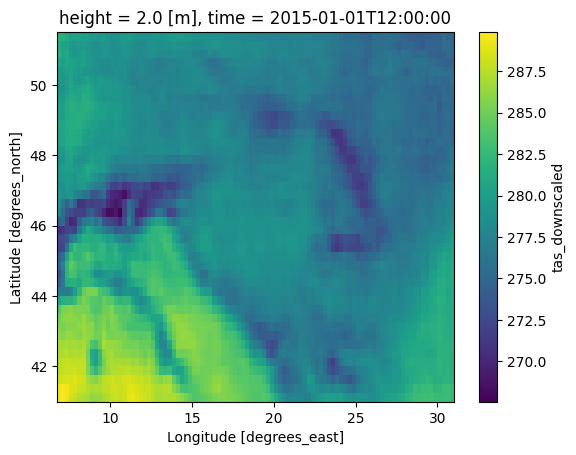

In [53]:
#Select the first time step
first_time_step = predicted_ds.isel(time=0).compute()  # Use .compute() if using Dask
first_time_step.plot()

pentru estimare model scenarii